In [1]:
import os
while not 'dataloaders' in os.listdir():
    os.chdir('../')
# os.listdir()

In [2]:
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)


Batch 1:
Sat Patches Shape: torch.Size([177, 3, 128, 128])
Map Patches Shape: torch.Size([177, 128, 128])


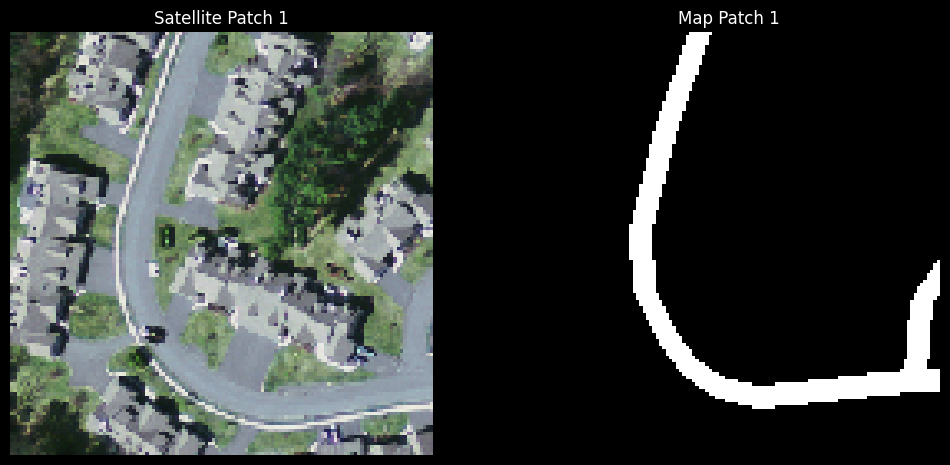

Batch 2:
Sat Patches Shape: torch.Size([254, 3, 128, 128])
Map Patches Shape: torch.Size([254, 128, 128])


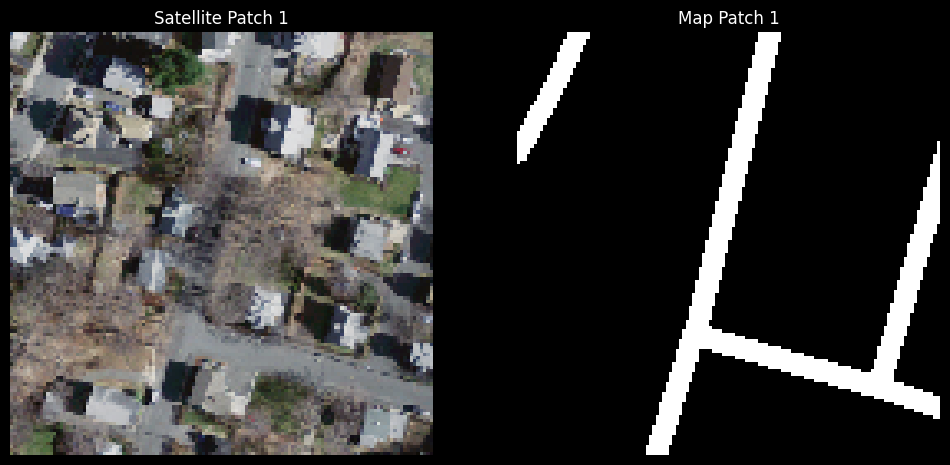

Batch 3:
Sat Patches Shape: torch.Size([61, 3, 128, 128])
Map Patches Shape: torch.Size([61, 128, 128])


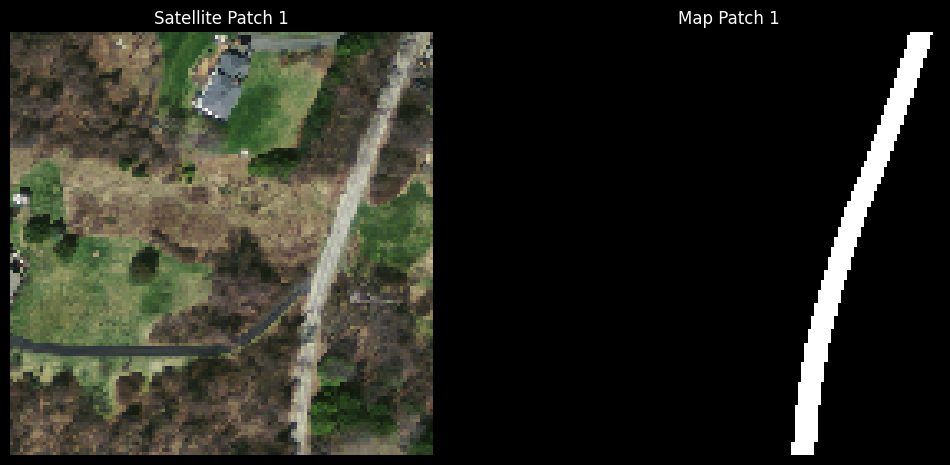

Batch 4:
Sat Patches Shape: torch.Size([81, 3, 128, 128])
Map Patches Shape: torch.Size([81, 128, 128])


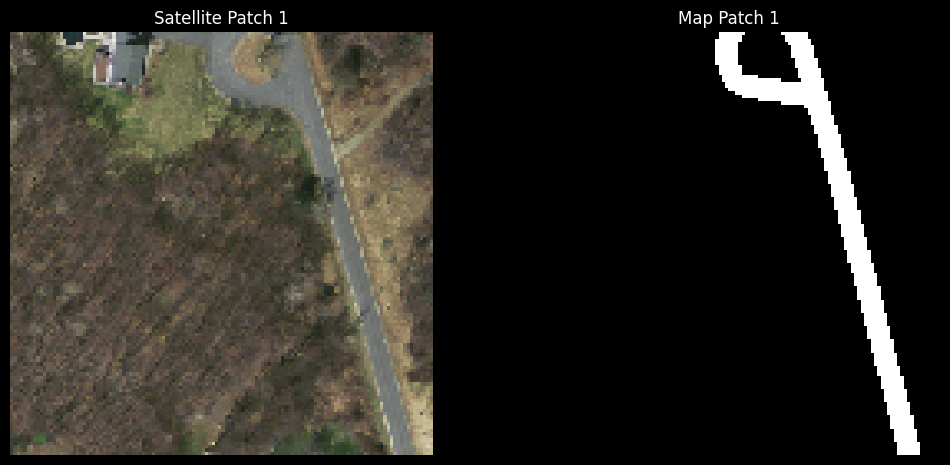

In [3]:
import numpy as np
import torch
import torch.nn as nn
import os
from torchvision.models import resnet50
import torch.optim as optim
from torch.utils.data import DataLoader
from dataloaders.mass_roads_dataloader import MassRoadsDataset, custom_collate_fn
from tqdm import tqdm
import matplotlib.pyplot as plt
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork

# --- Dataset and Hyperparameters ---
DATA_DIR = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'
CHECKPOINT_PATH = 'log_density_segmentation_checkpoint.pth'
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Hyperparameters and Training ---
EPOCHS = 300
ACCUMULATION_STEPS = 8  # Simulate larger batch size
# Noise schedule parameters
SIGMA_MIN = 0.01  # Minimum noise level
SIGMA_MAX = 0.3   # Maximum noise level
NUM_NOISE_LEVELS = 10  # Number of discrete noise levels

WINDOW_SIZE = 128
WINDOW_STRIDE = 64

# Generate noise levels
noise_levels = torch.logspace(
    start=torch.log10(torch.tensor(SIGMA_MIN)),
    end=torch.log10(torch.tensor(SIGMA_MAX)),
    steps=NUM_NOISE_LEVELS
).to(DEVICE)

# --- Initialize ResNet and Models ---
resnet = resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-2],  # Remove fully connected layers and avgpool
    nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to reduce spatial dimensions to 1x1
).to(DEVICE)
resnet = resnet.to(DEVICE)
for param in resnet.parameters():
    param.requires_grad = False

mlp = MLPs(
    input_dim=2048 + 1,  # ResNet features + noise level
    output_dim=WINDOW_SIZE * WINDOW_SIZE,  # Pixel-wise log-density
    units=[4096, 4096],
    layernorm=True,
    dropout=0.1
)

log_density_model = ScoreOrLogDensityNetwork(mlp, score_network=False).to(DEVICE)
# --- Save Final Model ---
def save_model(log_density_model, path="log_density_segmentation_model.pth"):
    torch.save(log_density_model.state_dict(), path)
    print(f"Model saved at {path}")


# --- Loss Functions ---
def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def combined_loss(pred, target):
    bce = nn.BCELoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice

# --- Optimizer ---
optimizer = optim.AdamW(log_density_model.parameters(), lr=LEARNING_RATE)

# --- Dataset and DataLoaders ---
train_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='train', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
test_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='test', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)


def plot_patches(sat_patches, map_patches, n_patches=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(min(n_patches, sat_patches.shape[0])):
        sat_patch = sat_patches[i].numpy().transpose(1, 2, 0) 
        map_patch = map_patches[i].numpy()

        ax[0].imshow(sat_patch)
        ax[0].set_title(f'Satellite Patch {i+1}')
        ax[0].axis('off')

        ax[1].imshow(map_patch, cmap='gray')
        ax[1].set_title(f'Map Patch {i+1}')
        ax[1].axis('off')

    plt.show()

for i, (sat_patches, map_patches) in enumerate(dataloader_train):
    print(f"Batch {i+1}:")
    print(f"Sat Patches Shape: {sat_patches.shape}")
    print(f"Map Patches Shape: {map_patches.shape}")

    plot_patches(sat_patches, map_patches, n_patches=1)
    if i > 2:
        break


In [ ]:
print(next(resnet.parameters()).device)  # Should print 'cuda' if using GPU
print(next(log_density_model.parameters()).device)
print(torch.cuda.memory_summary(device=DEVICE))


In [ ]:
def forward_pass(satellite_patches, noise_levels, resnet, log_density_model):
    # print(f"Satellite Patches Shape: {satellite_patches.shape}")  # Input shape: (B, C, H, W)

    # Step 1: Extract features using ResNet
    features = resnet(satellite_patches).flatten(start_dim=1)  # Shape: (B, 2048)
    # print(f"ResNet Features Shape: {features.shape}")

    # Step 2: Repeat features for multiple noise levels
    batch_size = features.size(0)
    num_noise_levels = len(noise_levels)
    features = features.repeat_interleave(num_noise_levels, dim=0)  # Shape: (B * NUM_NOISE_LEVELS, 2048)
    # print(f"Repeated Features Shape: {features.shape}")

    # Step 3: Create noise tensor
    noise_tensor = noise_levels.repeat(batch_size, 1).view(-1, 1)  # Shape: (B * NUM_NOISE_LEVELS, 1)
    # print(f"Noise Tensor Shape: {noise_tensor.shape}")

    # Step 4: Concatenate features with noise levels
    features_with_noise = torch.cat([features, noise_tensor], dim=1)  # Shape: (B * NUM_NOISE_LEVELS, 2049)
    # print(f"Features with Noise Shape: {features_with_noise.shape}")

    # Step 5: Predict pixel-wise log-density map
    predictions = log_density_model(features_with_noise)  # Shape: (B * NUM_NOISE_LEVELS, WINDOW_SIZE * WINDOW_SIZE)
    # print(f"Predictions Shape Before Reshaping: {predictions.shape}")

    predictions = predictions.view(batch_size, num_noise_levels, 1, WINDOW_SIZE, WINDOW_SIZE)  # Reshape to (B, NUM_NOISE_LEVELS, 1, H, W)
    # print(f"Predictions Shape After Reshaping: {predictions.shape}")

    return predictions




# # Inputs
# satellite_patches = torch.randn(4, 3, 128, 128).to(DEVICE)  # Batch of 4 satellite image patches
# noise_levels = torch.logspace(-2, -0.3, steps=10).to(DEVICE)  # 10 noise levels

# # Forward pass
# predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)

# # Output shape
# print(predictions.shape)  # Expected: (B, 1, 128, 128)


# # Satellite Patches Shape: torch.Size([4, 3, 128, 128])
# # ResNet Features Shape: torch.Size([4, 2048])
# # Repeated Features Shape: torch.Size([40, 2048])
# # Noise Tensor Shape: torch.Size([40, 1])
# # Features with Noise Shape: torch.Size([40, 2049])
# # Predictions Shape Before Reshaping: torch.Size([40, 16384])
# # Predictions Shape After Reshaping: torch.Size([4, 10, 1, 128, 128])
# # torch.Size([4, 10, 1, 128, 128])

In [ ]:
def train_model(
    resnet, 
    log_density_model, 
    train_loader, 
    noise_levels, 
    optimizer, 
    device, 
    num_epochs, 
    accumulation_steps, 
    checkpoint_path="mulde_checkpoint.pth"
):
    resnet.eval()  # ResNet is frozen during training
    log_density_model.train()  # Only train the log-density model
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        optimizer.zero_grad()  # Zero gradients at the start of each epoch
        for batch_idx, (satellite_patches, road_maps) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            # Skip empty batches
            if satellite_patches.numel() == 0 or road_maps.numel() == 0:
                # print(f"Skipping empty batch {batch_idx + 1}")
                continue
            
            # Move data to the device
            satellite_patches = satellite_patches.to(device)
            road_maps = road_maps.to(device).float() / 255.0  # Normalize ground truth to [0, 1]
            road_maps = road_maps.unsqueeze(1)  # Add channel dimension to match input shape (B, 1, H, W)
            
            # Forward pass
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
            predictions = predictions[:, 0, :, :, :]  # Use the predictions for noise level 0 (first noise level)
            
            # Compute loss
            loss = combined_loss(torch.sigmoid(predictions), road_maps)
            loss = loss / accumulation_steps  # Scale loss by accumulation steps
            
            # Backward pass
            loss.backward()
            
            # Perform optimizer step after `accumulation_steps` batches
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()  # Reset gradients after updating weights
            
            # Accumulate loss
            epoch_loss += loss.item()
        
        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': log_density_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, checkpoint_path)

        print(f"Checkpoint saved at {checkpoint_path}")

    print("Training complete.")


In [15]:
train_model(
    resnet=resnet,
    log_density_model=log_density_model,
    train_loader=dataloader_train,
    noise_levels=noise_levels,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_path=CHECKPOINT_PATH,
)



Epoch 1/300:   3%|▎         | 32/1108 [00:30<13:45,  1.30it/s]

Skipping empty batch 32


Epoch 1/300:   4%|▍         | 47/1108 [00:46<17:48,  1.01s/it]

Skipping empty batch 48


Epoch 1/300:   6%|▌         | 63/1108 [00:59<09:01,  1.93it/s]

Skipping empty batch 62


Epoch 1/300:   8%|▊         | 89/1108 [01:21<12:29,  1.36it/s]

Skipping empty batch 89


Epoch 1/300:  20%|██        | 224/1108 [03:18<12:29,  1.18it/s]

Skipping empty batch 225


Epoch 1/300:  24%|██▍       | 268/1108 [03:59<12:31,  1.12it/s]


KeyboardInterrupt: 

In [ ]:
# --- Evaluation Function ---
def evaluate(model, resnet, dataloader, noise_levels, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for satellite_patches, road_maps in tqdm(dataloader, desc="Evaluating"):
            satellite_patches = satellite_patches.to(device)
            road_maps = road_maps.to(device).float() / 255.0
            
            # Forward pass
            predictions = forward_pass(satellite_patches, noise_levels, resnet, model)
            predictions = predictions[:, 0, :, :, :]  # Use the predictions for noise level 0
            
            # Compute loss
            loss = combined_loss(torch.sigmoid(predictions), road_maps)
            total_loss += loss.item()

    return total_loss / len(dataloader)

val_loss = evaluate(
    model=log_density_model,
    resnet=resnet,
    dataloader=dataloader_test,
    noise_levels=noise_levels,
    device=DEVICE,
)
print(f"Validation Loss: {val_loss:.4f}")


In [ ]:
save_model(log_density_model, "log_density_segmentation_model.pth")

In [ ]:
# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()
